In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.cuda()

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size]).cuda()
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [10]:
models = {
    'VAE1': Net(1, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4).cuda(),
    'VAE2': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4).cuda()
}

fixed_z = {
    'VAE1': torch.randn((50, 1)).cuda(),
    'VAE2': torch.randn((50, 2)).cuda()
}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [12]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.cuda()
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        print(k)
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.cpu().numpy()
            fixed_gen = models[k].decode(fixed_z[k]).data.cpu().numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

/cephfs/home/seliverstov/oml/env/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses VAE1: 0.8625 VAE2: 0.9119
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE1: 0.4584 VAE2: 0.4804
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE1: 0.4264 VAE2: 0.4346
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE1: 0.3836 VAE2: 0.3870
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE1: 0.3751 VAE2: 0.3723
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE1: 0.3446 VAE2: 0.3372
VAE1


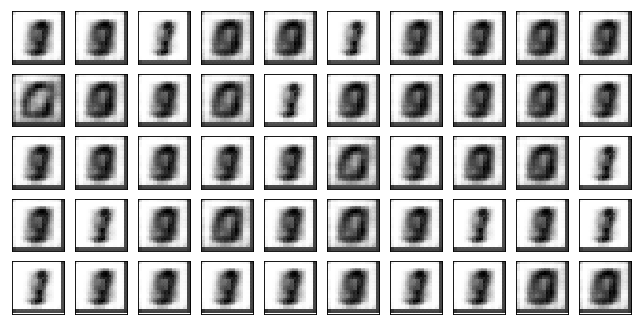

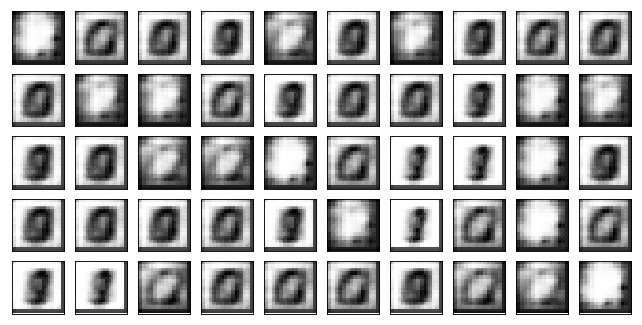

VAE2


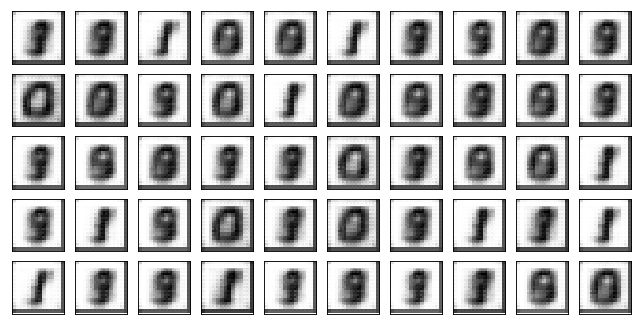

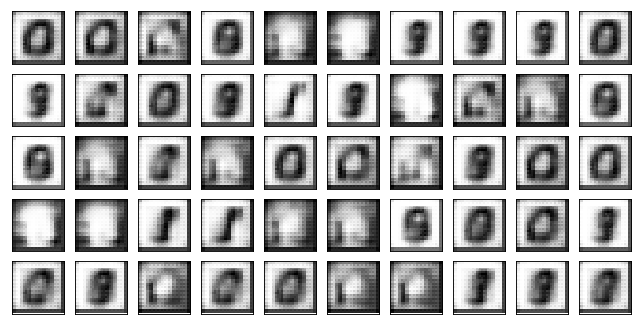

Test losses: VAE1: 0.3391/1.7940 VAE2: 0.3293/2.5529
Train Epoch: 2 [0/50000 (0%)]	Losses VAE1: 0.3431 VAE2: 0.3362
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE1: 0.3214 VAE2: 0.3089
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE1: 0.3041 VAE2: 0.2926
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE1: 0.2816 VAE2: 0.2684
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE1: 0.2711 VAE2: 0.2603
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE1: 0.2780 VAE2: 0.2579
VAE1


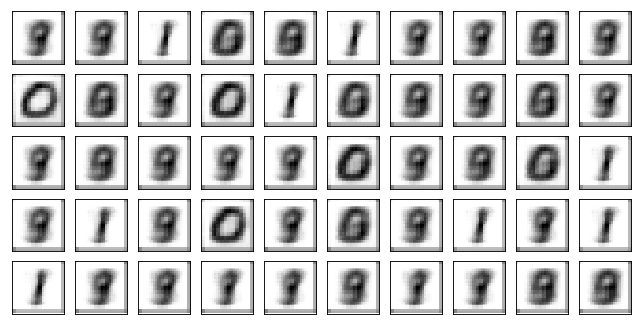

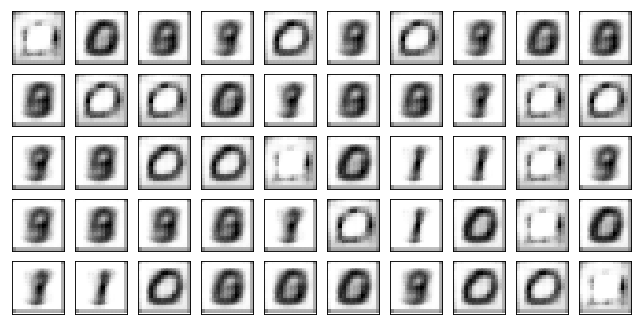

VAE2


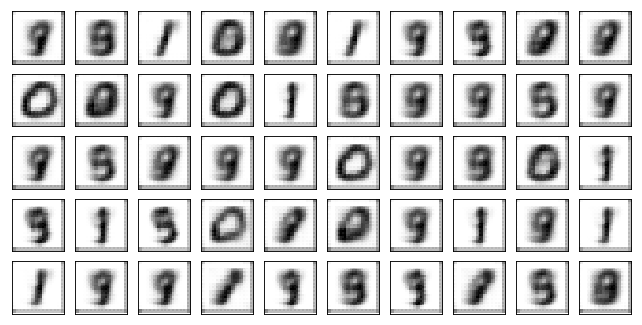

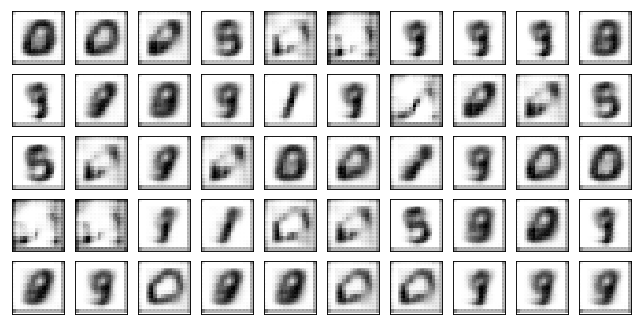

Test losses: VAE1: 0.2662/1.8222 VAE2: 0.2443/2.8178
Train Epoch: 3 [0/50000 (0%)]	Losses VAE1: 0.2677 VAE2: 0.2496
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE1: 0.2596 VAE2: 0.2427
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE1: 0.2564 VAE2: 0.2234
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE1: 0.2488 VAE2: 0.2282
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE1: 0.2508 VAE2: 0.2297
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE1: 0.2526 VAE2: 0.2297
VAE1


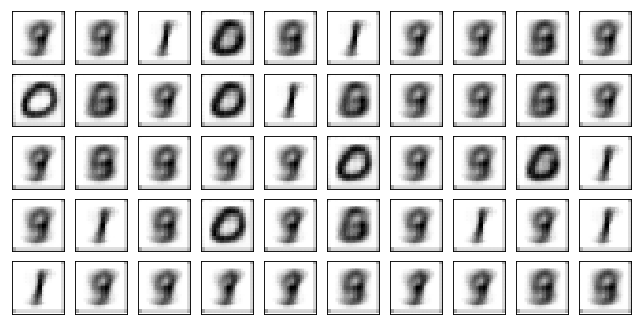

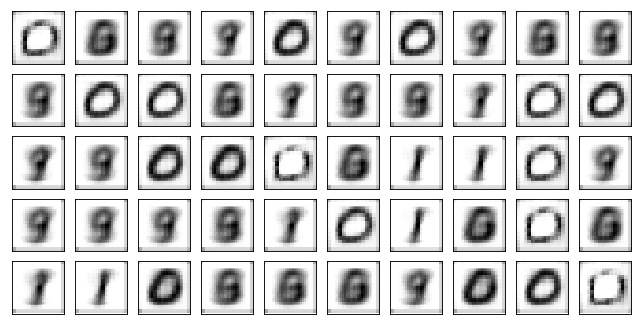

VAE2


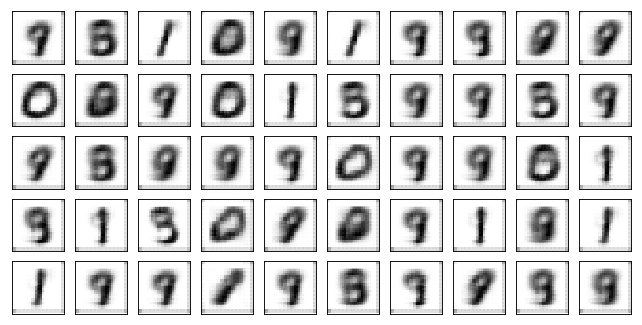

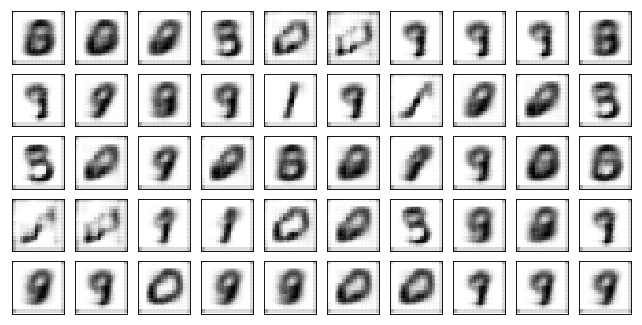

Test losses: VAE1: 0.2435/1.7221 VAE2: 0.2174/3.0502
Train Epoch: 4 [0/50000 (0%)]	Losses VAE1: 0.2449 VAE2: 0.2203
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE1: 0.2299 VAE2: 0.2115
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE1: 0.2349 VAE2: 0.2188
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE1: 0.2416 VAE2: 0.2203
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE1: 0.2254 VAE2: 0.2017
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE1: 0.2587 VAE2: 0.2329
VAE1


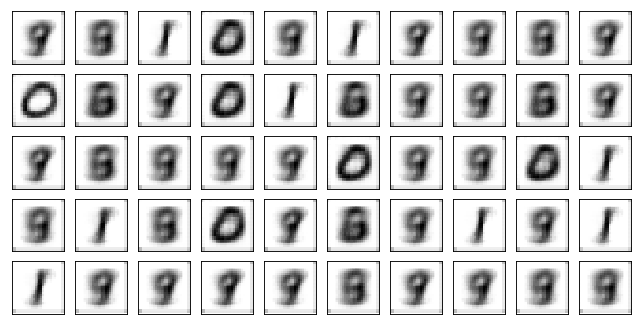

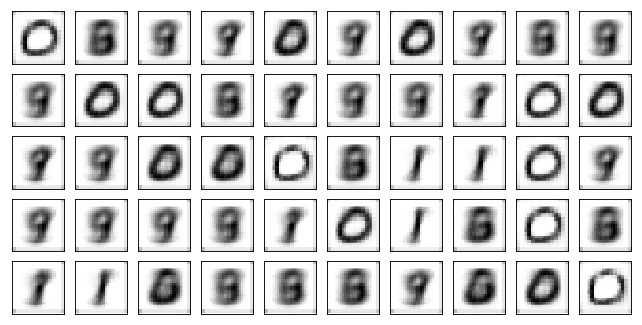

VAE2


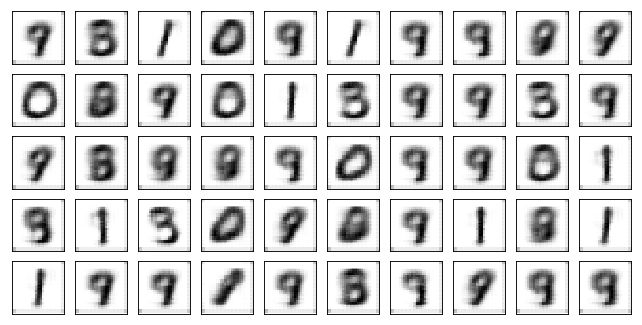

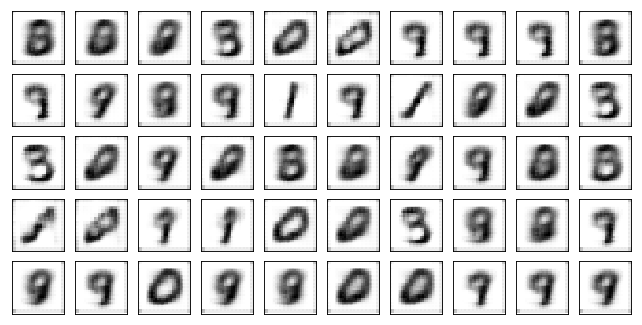

Test losses: VAE1: 0.2359/1.7926 VAE2: 0.2070/3.1877
Train Epoch: 5 [0/50000 (0%)]	Losses VAE1: 0.2445 VAE2: 0.2195
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE1: 0.2341 VAE2: 0.2126
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE1: 0.2368 VAE2: 0.2114
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE1: 0.2219 VAE2: 0.2013
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE1: 0.2377 VAE2: 0.2093
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE1: 0.2516 VAE2: 0.2270
VAE1


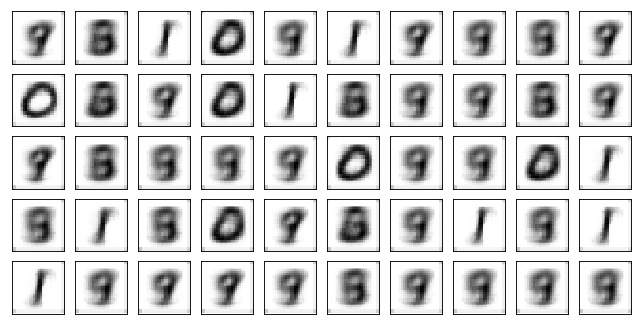

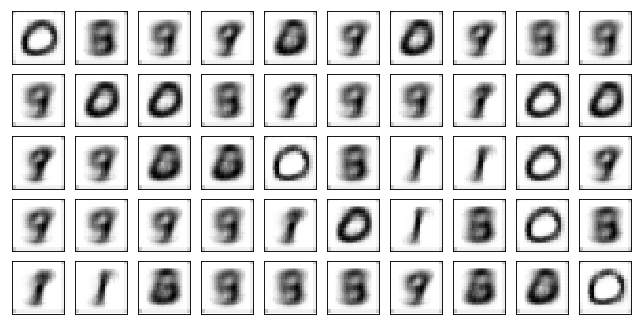

VAE2


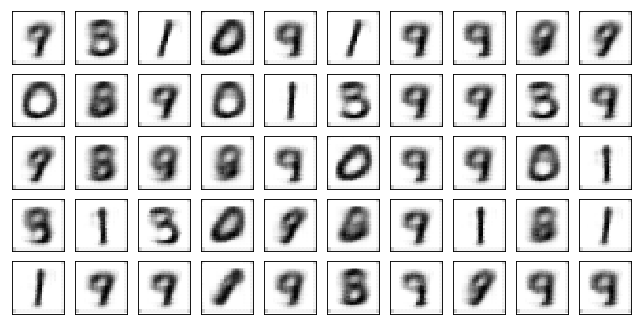

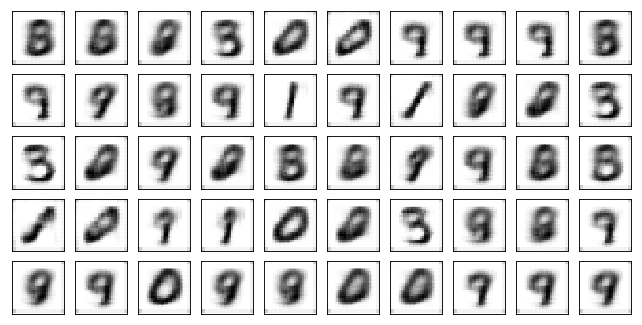

Test losses: VAE1: 0.2308/1.9023 VAE2: 0.2013/3.2576
Train Epoch: 6 [0/50000 (0%)]	Losses VAE1: 0.2453 VAE2: 0.2211
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE1: 0.2082 VAE2: 0.1830
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE1: 0.2240 VAE2: 0.1986
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE1: 0.2119 VAE2: 0.1821
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE1: 0.2269 VAE2: 0.2050
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE1: 0.2205 VAE2: 0.1942
VAE1


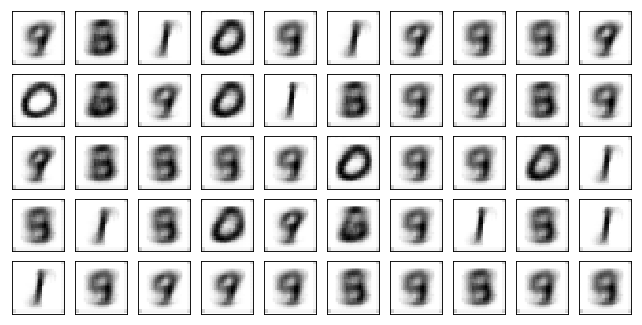

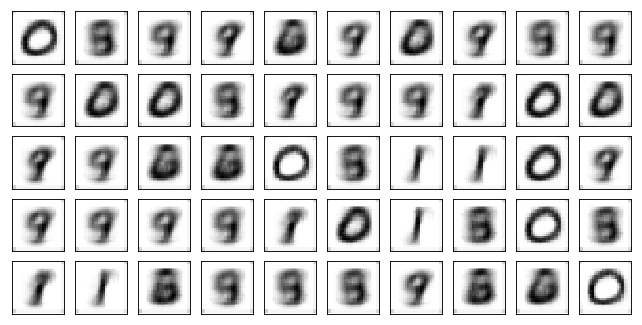

VAE2


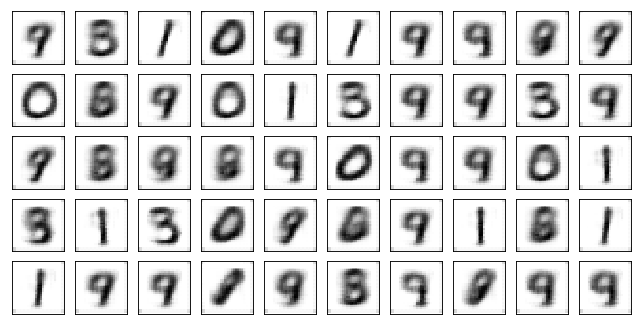

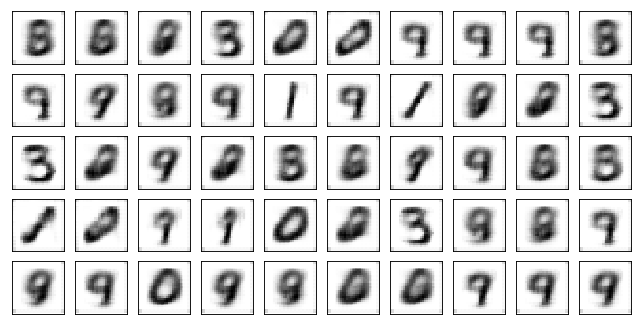

Test losses: VAE1: 0.2270/1.9582 VAE2: 0.1983/3.3578
Train Epoch: 7 [0/50000 (0%)]	Losses VAE1: 0.2384 VAE2: 0.2102
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE1: 0.2328 VAE2: 0.2018
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE1: 0.2294 VAE2: 0.2085
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE1: 0.2309 VAE2: 0.2035
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE1: 0.2167 VAE2: 0.1914
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE1: 0.2406 VAE2: 0.2072
VAE1


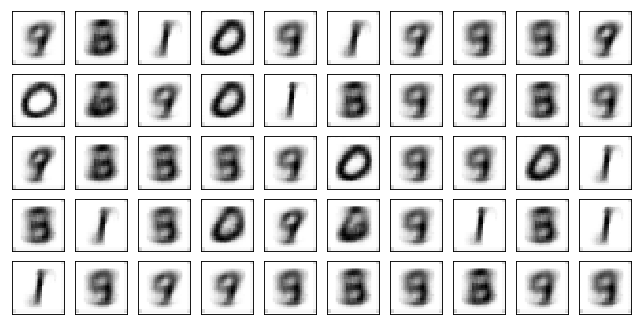

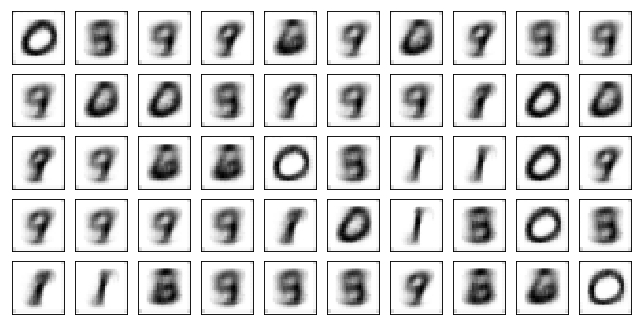

VAE2


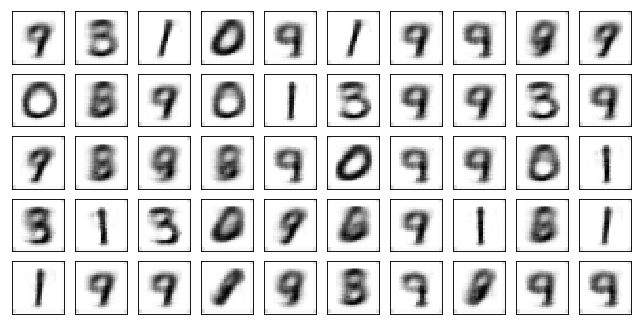

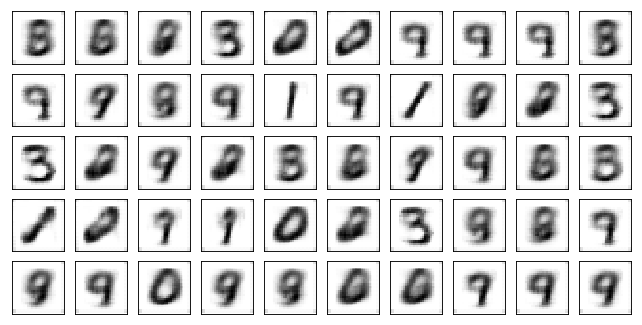

Test losses: VAE1: 0.2239/2.0690 VAE2: 0.1952/3.4542
Train Epoch: 8 [0/50000 (0%)]	Losses VAE1: 0.2437 VAE2: 0.2142
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE1: 0.2081 VAE2: 0.1823
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE1: 0.2278 VAE2: 0.2051
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE1: 0.2330 VAE2: 0.2105
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE1: 0.2087 VAE2: 0.1807
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE1: 0.2439 VAE2: 0.2090
VAE1


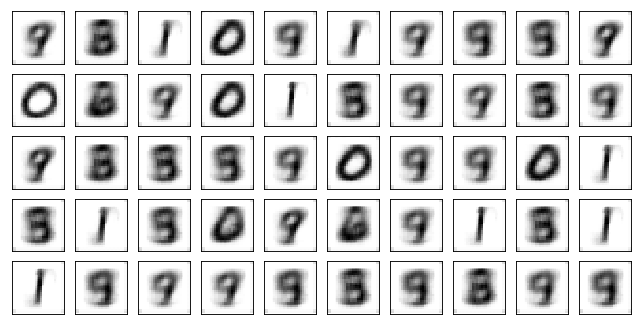

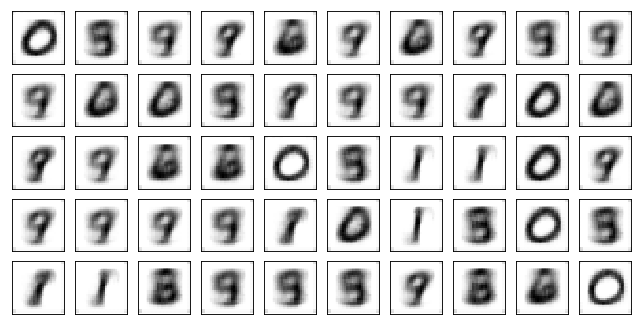

VAE2


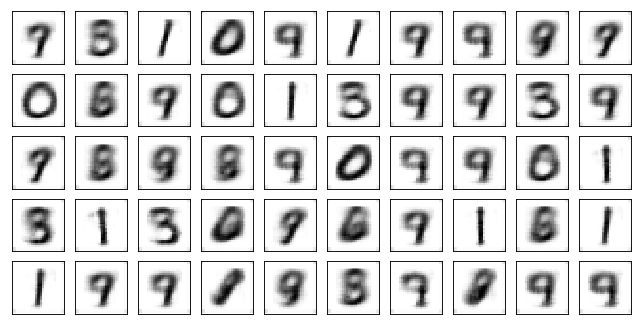

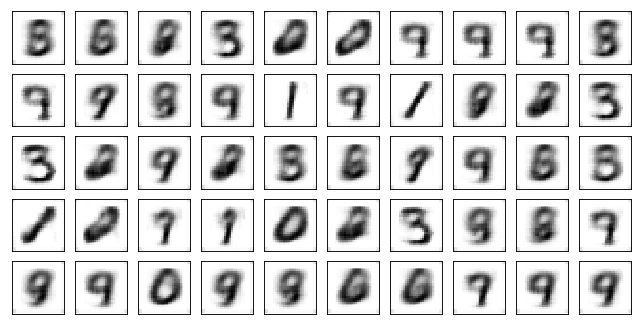

Test losses: VAE1: 0.2214/2.2052 VAE2: 0.1934/3.4792
Train Epoch: 9 [0/50000 (0%)]	Losses VAE1: 0.2083 VAE2: 0.1821
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE1: 0.2126 VAE2: 0.1880
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE1: 0.2051 VAE2: 0.1818
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE1: 0.2270 VAE2: 0.1976
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE1: 0.2238 VAE2: 0.2015
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE1: 0.2115 VAE2: 0.1932
VAE1


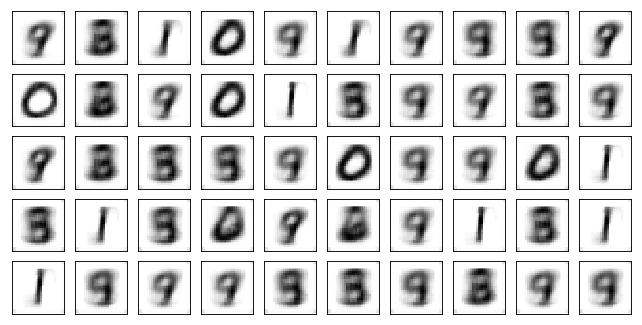

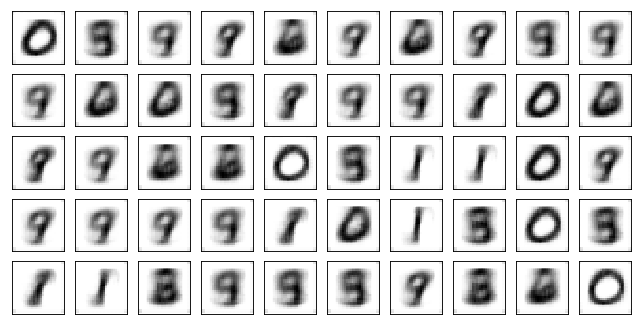

VAE2


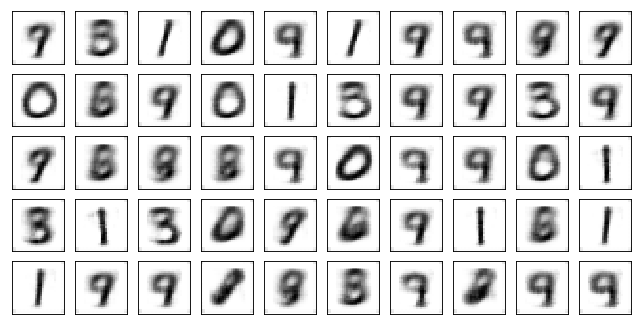

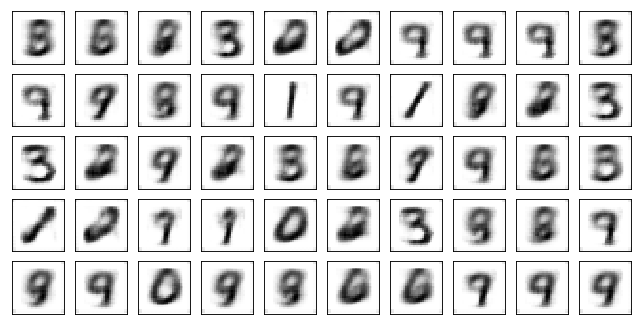

Test losses: VAE1: 0.2198/2.1588 VAE2: 0.1915/3.5785
Train Epoch: 10 [0/50000 (0%)]	Losses VAE1: 0.2215 VAE2: 0.1895
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE1: 0.2249 VAE2: 0.1972
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE1: 0.1985 VAE2: 0.1803
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE1: 0.2126 VAE2: 0.1901
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE1: 0.2318 VAE2: 0.2067
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE1: 0.1883 VAE2: 0.1644
VAE1


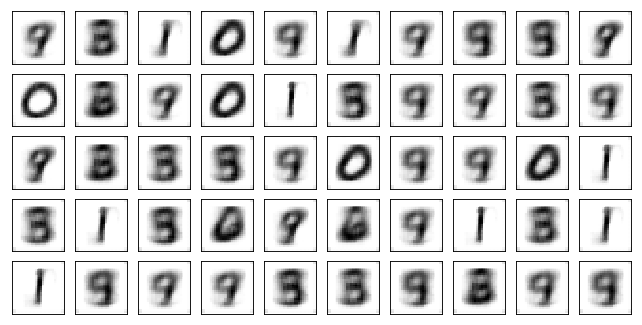

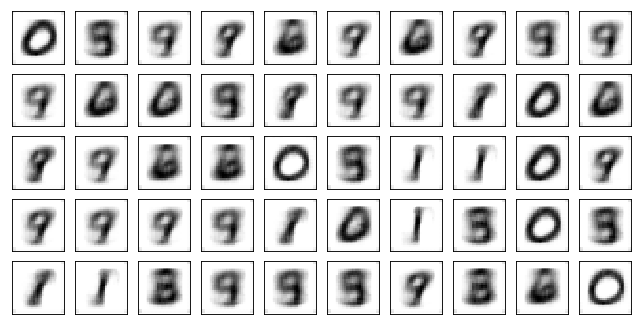

VAE2


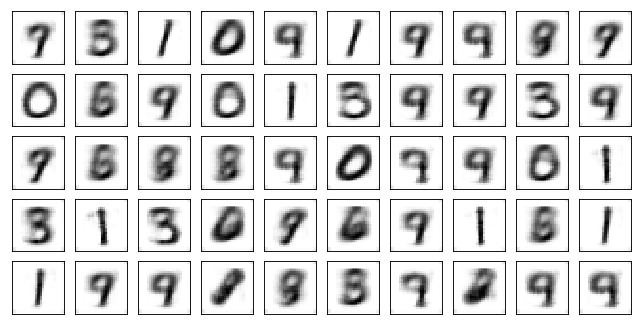

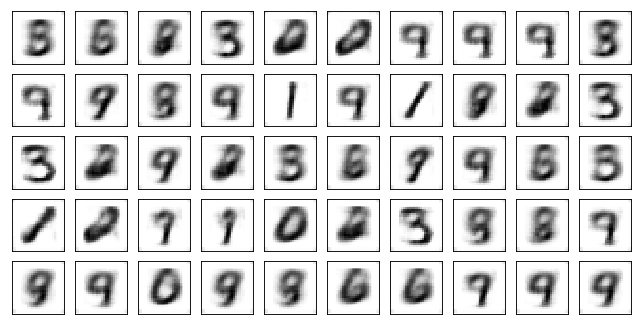

Test losses: VAE1: 0.2179/2.2546 VAE2: 0.1899/3.5529
Train Epoch: 11 [0/50000 (0%)]	Losses VAE1: 0.2277 VAE2: 0.2056
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE1: 0.2180 VAE2: 0.1964
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE1: 0.2225 VAE2: 0.1942
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE1: 0.2246 VAE2: 0.1895
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE1: 0.2054 VAE2: 0.1882
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE1: 0.2217 VAE2: 0.1878
VAE1


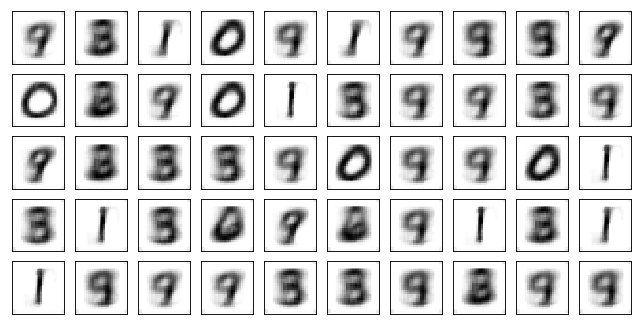

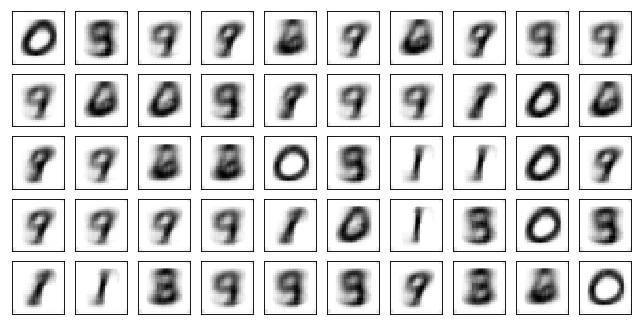

VAE2


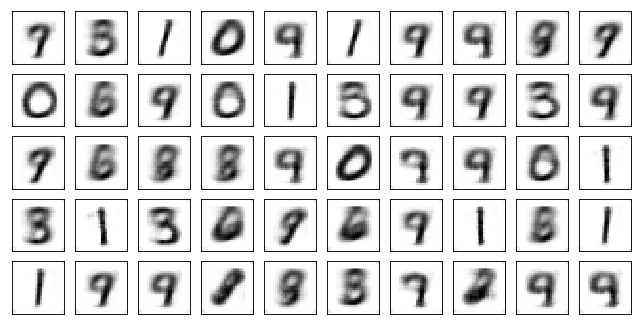

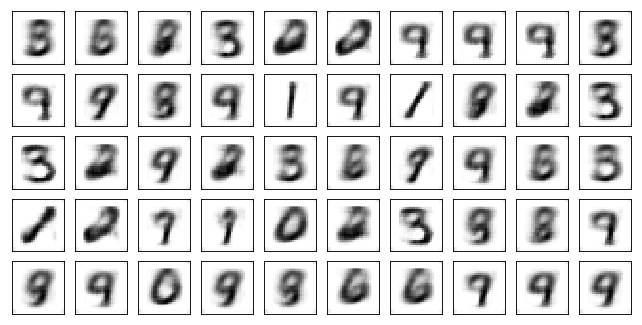

Test losses: VAE1: 0.2166/2.3952 VAE2: 0.1884/3.6992
Train Epoch: 12 [0/50000 (0%)]	Losses VAE1: 0.2088 VAE2: 0.1834
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE1: 0.2022 VAE2: 0.1777
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE1: 0.2133 VAE2: 0.1878
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE1: 0.2078 VAE2: 0.1803
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE1: 0.1992 VAE2: 0.1758
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE1: 0.2143 VAE2: 0.1945
VAE1


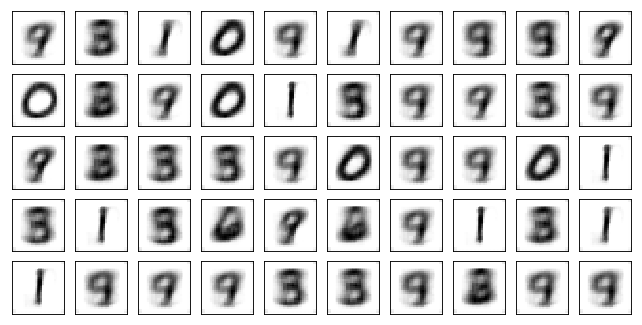

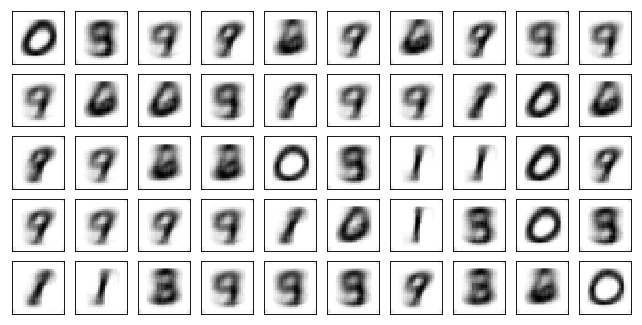

VAE2


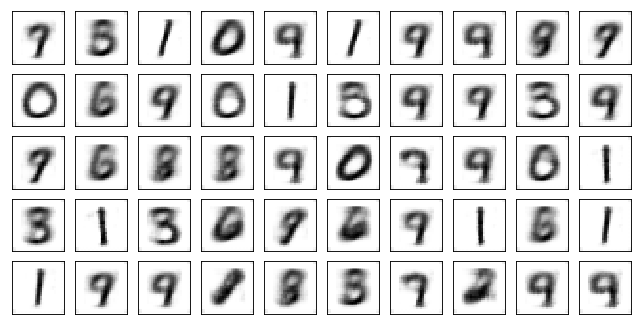

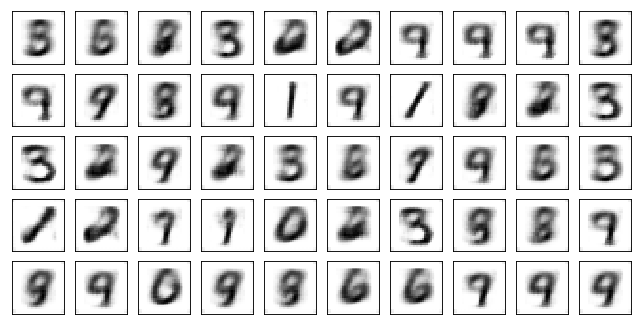

Test losses: VAE1: 0.2155/2.3615 VAE2: 0.1869/3.7870
Train Epoch: 13 [0/50000 (0%)]	Losses VAE1: 0.2049 VAE2: 0.1784
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE1: 0.2205 VAE2: 0.1975
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE1: 0.2072 VAE2: 0.1797
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE1: 0.2125 VAE2: 0.1858
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE1: 0.2203 VAE2: 0.1892
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE1: 0.2247 VAE2: 0.2007
VAE1


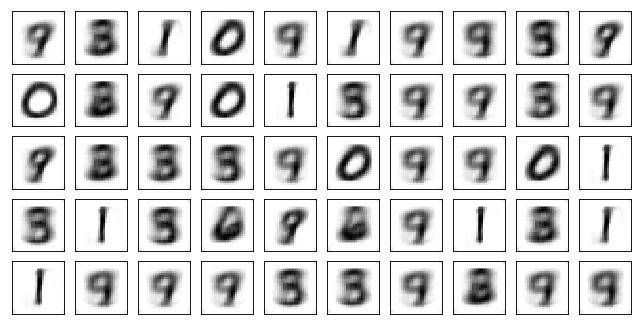

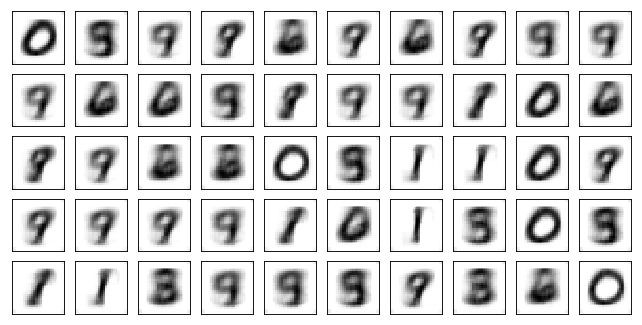

VAE2


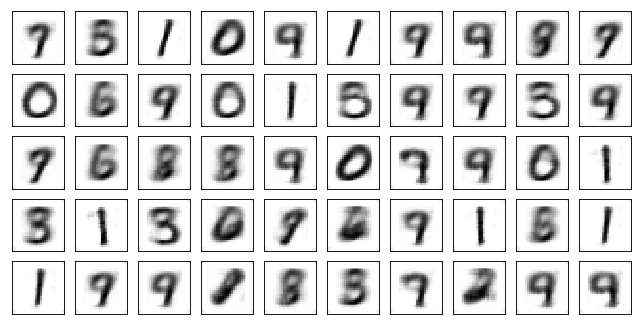

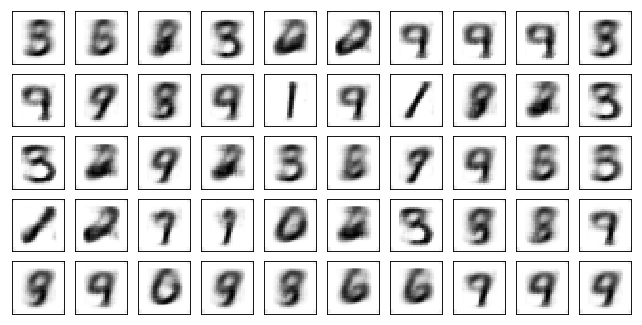

Test losses: VAE1: 0.2147/2.3352 VAE2: 0.1860/3.7871
Train Epoch: 14 [0/50000 (0%)]	Losses VAE1: 0.2162 VAE2: 0.1867
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE1: 0.2179 VAE2: 0.1943
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE1: 0.2275 VAE2: 0.1979
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE1: 0.1983 VAE2: 0.1697
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE1: 0.2061 VAE2: 0.1780
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE1: 0.2025 VAE2: 0.1854
VAE1


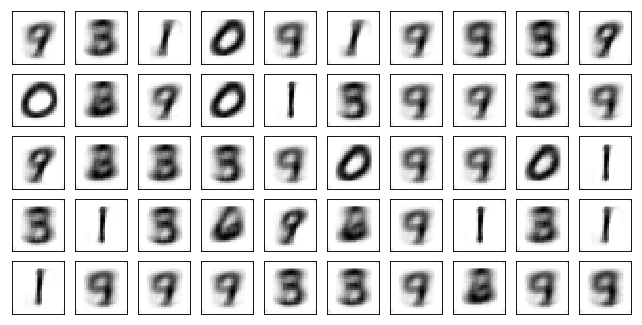

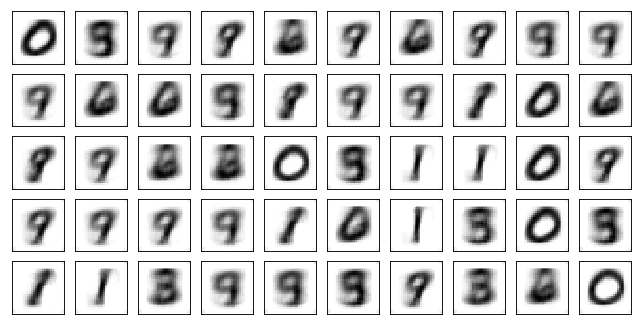

VAE2


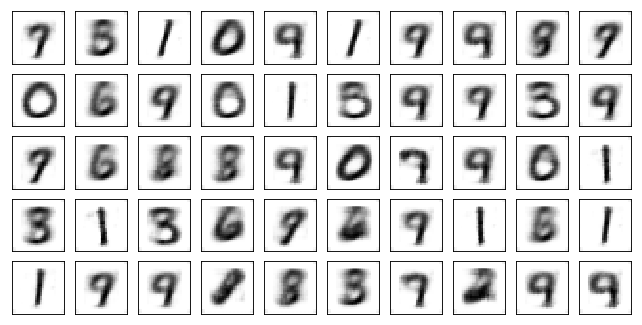

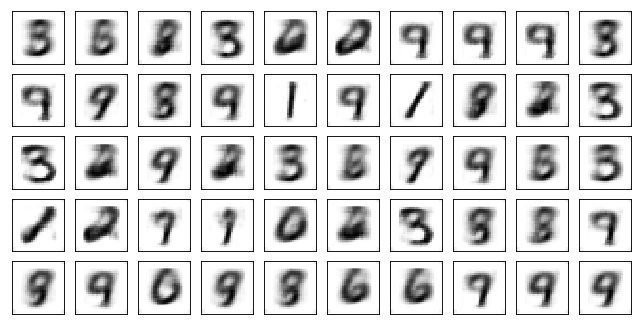

Test losses: VAE1: 0.2139/2.3865 VAE2: 0.1850/3.7567
Train Epoch: 15 [0/50000 (0%)]	Losses VAE1: 0.2267 VAE2: 0.2019
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE1: 0.2297 VAE2: 0.2018
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE1: 0.2242 VAE2: 0.2020
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE1: 0.2216 VAE2: 0.1803
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE1: 0.2173 VAE2: 0.1876
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE1: 0.2045 VAE2: 0.1868
VAE1


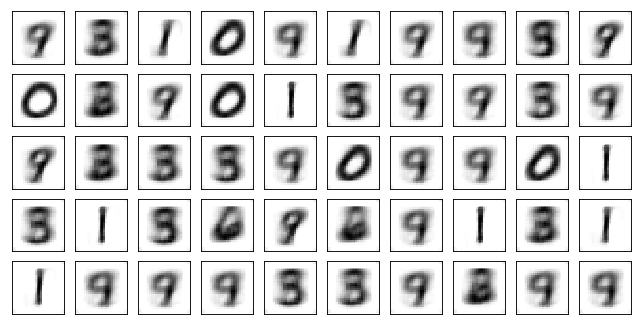

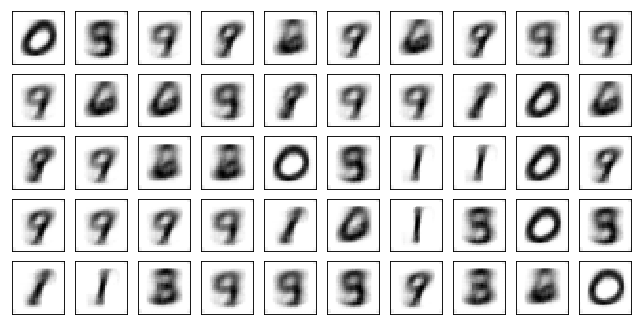

VAE2


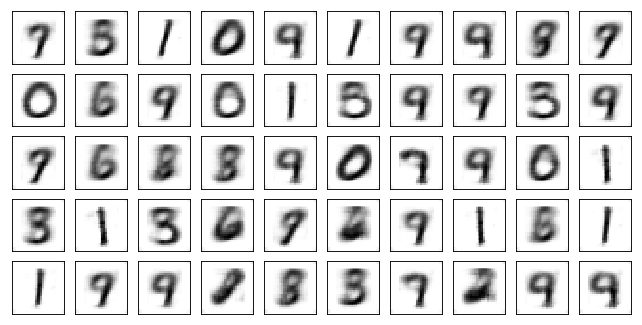

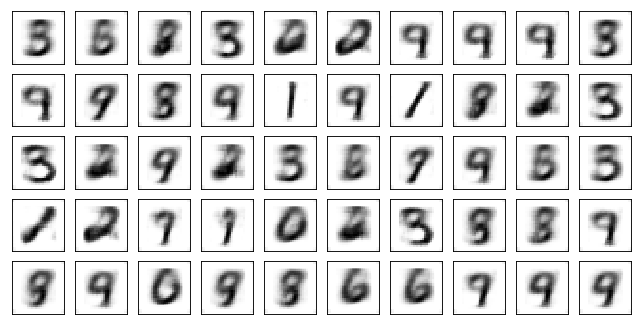

Test losses: VAE1: 0.2127/2.4518 VAE2: 0.1840/3.7999
Train Epoch: 16 [0/50000 (0%)]	Losses VAE1: 0.2057 VAE2: 0.1842
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE1: 0.2229 VAE2: 0.1928
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE1: 0.2246 VAE2: 0.2025
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE1: 0.2157 VAE2: 0.1896
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE1: 0.2493 VAE2: 0.2122
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE1: 0.2085 VAE2: 0.1816
VAE1


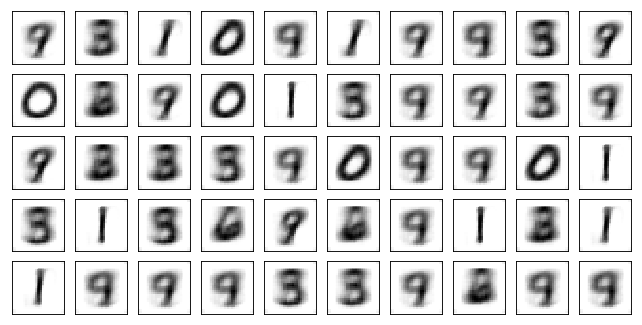

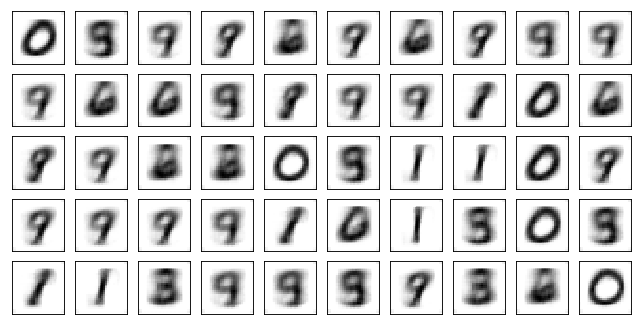

VAE2


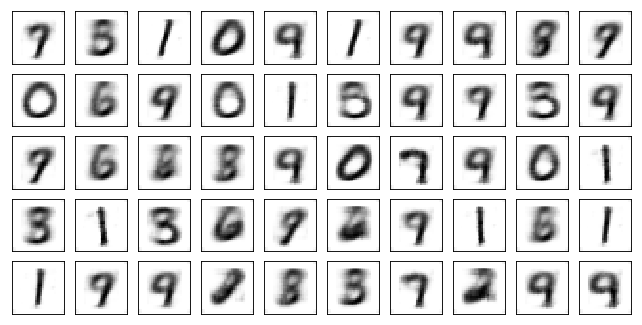

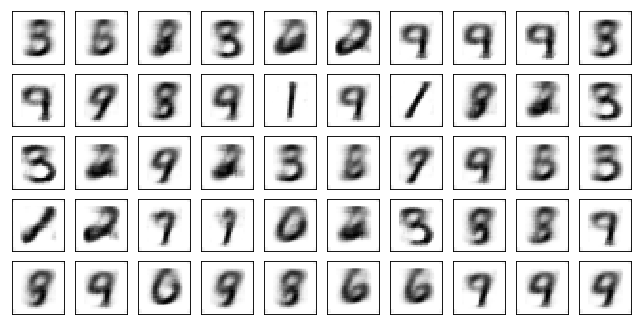

Test losses: VAE1: 0.2121/2.4456 VAE2: 0.1827/3.8144
Train Epoch: 17 [0/50000 (0%)]	Losses VAE1: 0.2153 VAE2: 0.1916
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE1: 0.2228 VAE2: 0.1938
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE1: 0.2263 VAE2: 0.1919
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE1: 0.2034 VAE2: 0.1835
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE1: 0.1979 VAE2: 0.1752
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE1: 0.1949 VAE2: 0.1732
VAE1


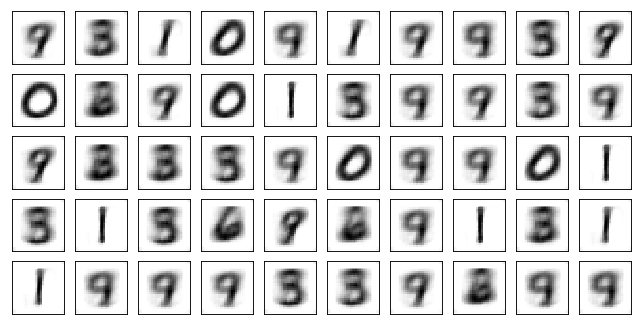

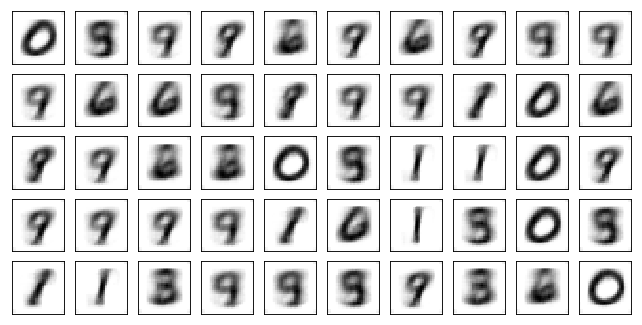

VAE2


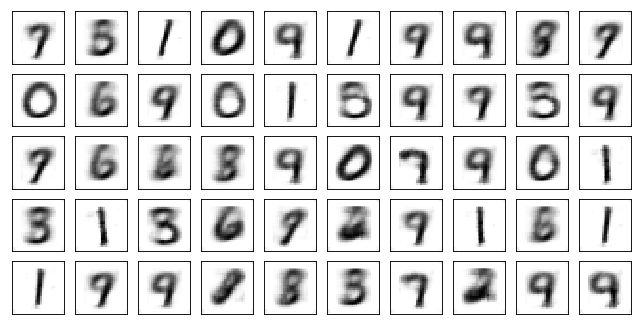

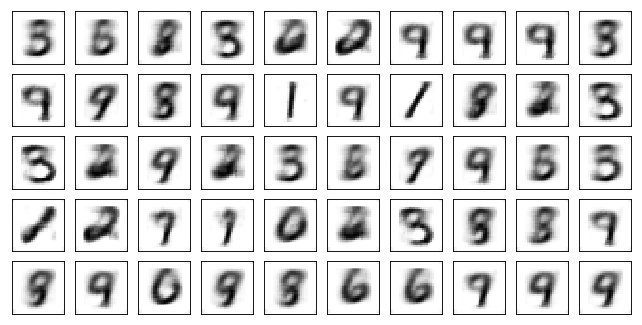

Test losses: VAE1: 0.2112/2.5156 VAE2: 0.1821/3.9142
Train Epoch: 18 [0/50000 (0%)]	Losses VAE1: 0.2049 VAE2: 0.1742
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE1: 0.2143 VAE2: 0.1884
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE1: 0.2017 VAE2: 0.1778
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE1: 0.2239 VAE2: 0.2028
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE1: 0.2159 VAE2: 0.1886
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE1: 0.2198 VAE2: 0.1859
VAE1


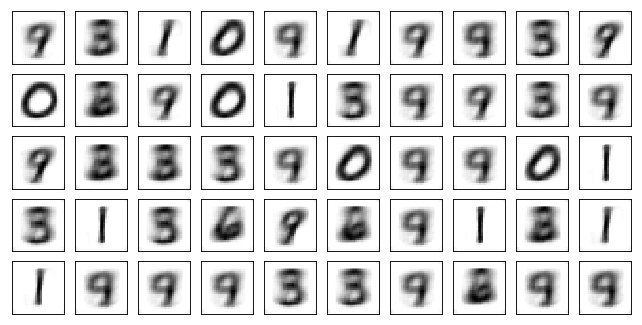

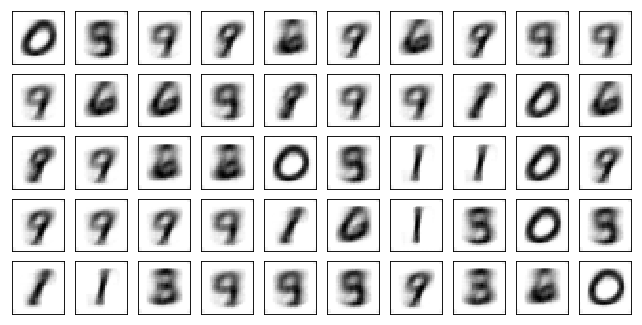

VAE2


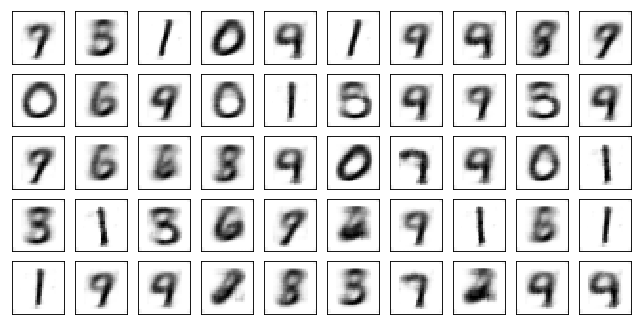

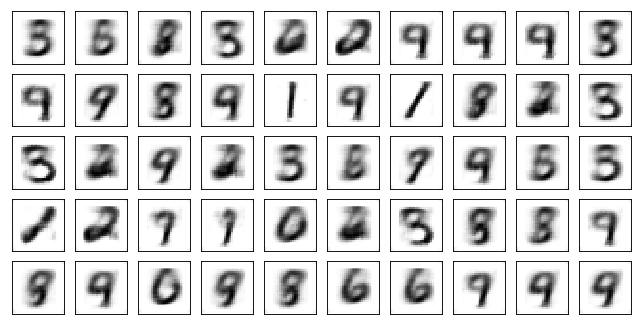

Test losses: VAE1: 0.2108/2.4958 VAE2: 0.1817/3.9817
Train Epoch: 19 [0/50000 (0%)]	Losses VAE1: 0.2148 VAE2: 0.1868
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE1: 0.2078 VAE2: 0.1897
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE1: 0.2016 VAE2: 0.1814
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE1: 0.2260 VAE2: 0.1915
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE1: 0.2022 VAE2: 0.1794
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE1: 0.2045 VAE2: 0.1795
VAE1


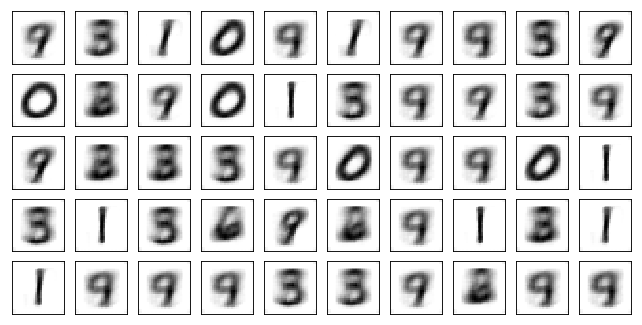

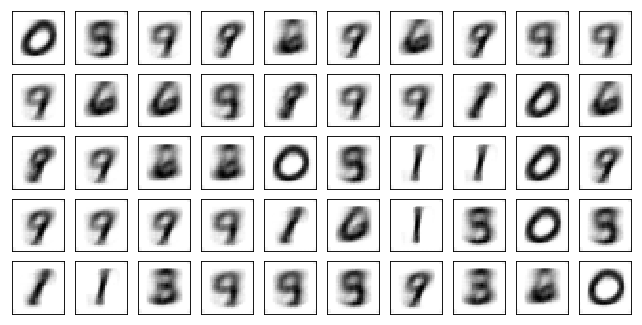

VAE2


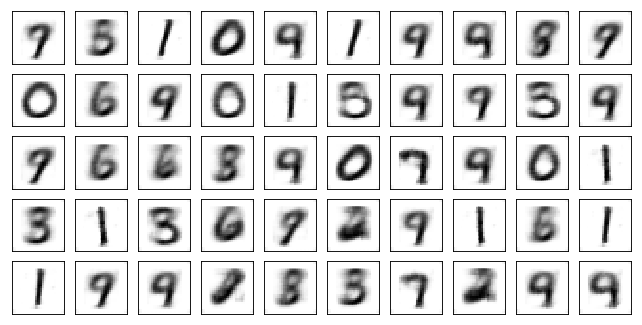

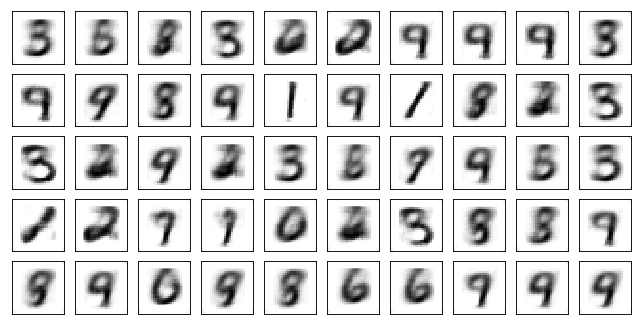

Test losses: VAE1: 0.2102/2.4417 VAE2: 0.1809/4.0031
Train Epoch: 20 [0/50000 (0%)]	Losses VAE1: 0.2072 VAE2: 0.1785
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE1: 0.2126 VAE2: 0.1874
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE1: 0.2058 VAE2: 0.1860
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE1: 0.1955 VAE2: 0.1694
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE1: 0.2082 VAE2: 0.1763
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE1: 0.2049 VAE2: 0.1852
VAE1


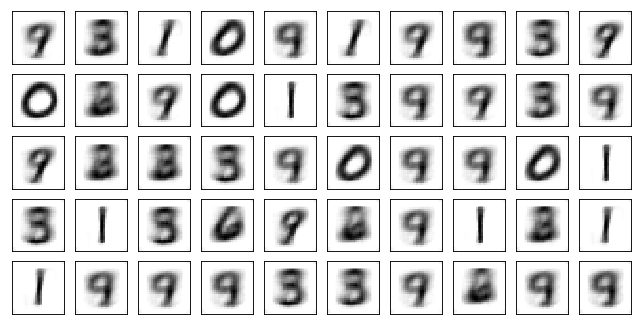

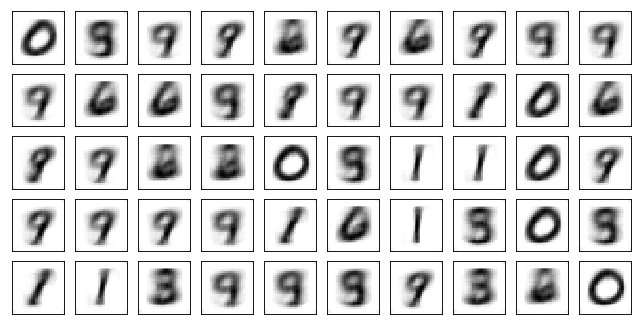

VAE2


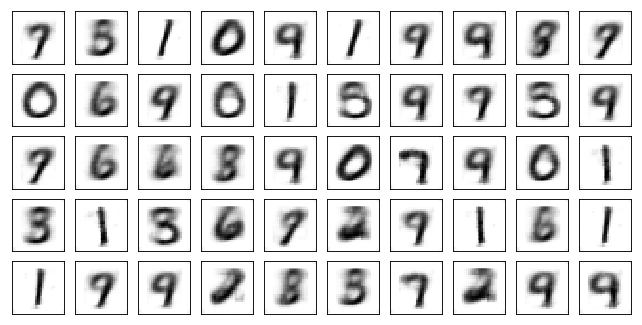

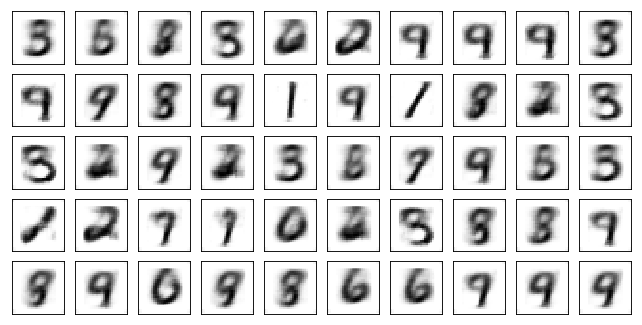

Test losses: VAE1: 0.2100/2.5394 VAE2: 0.1801/3.9441
Train Epoch: 21 [0/50000 (0%)]	Losses VAE1: 0.1862 VAE2: 0.1647
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE1: 0.2129 VAE2: 0.1838
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE1: 0.2257 VAE2: 0.1954
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE1: 0.2233 VAE2: 0.1931
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE1: 0.2161 VAE2: 0.1891
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE1: 0.2115 VAE2: 0.1924
VAE1


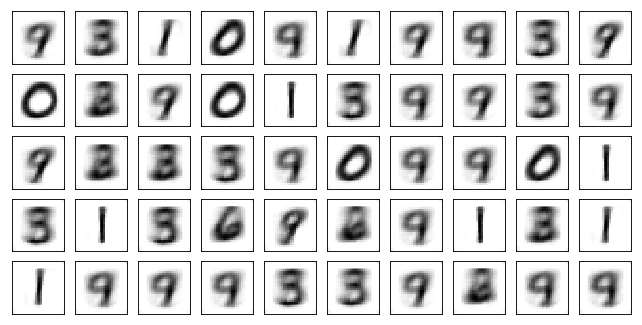

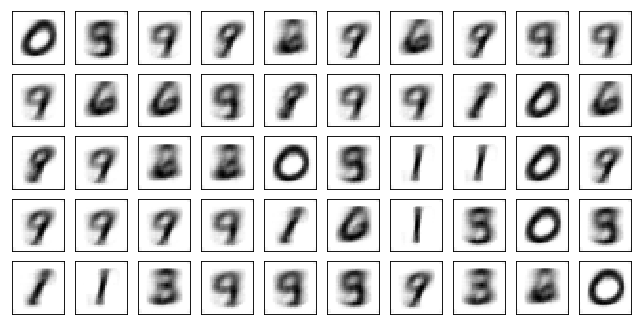

VAE2


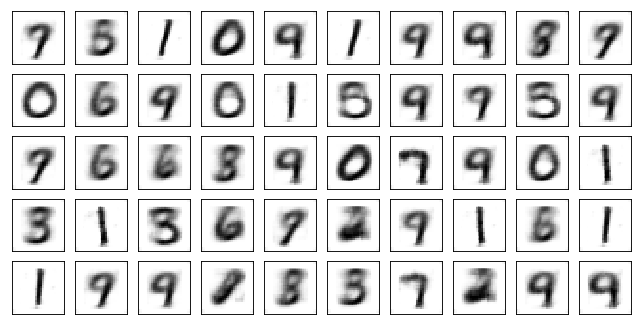

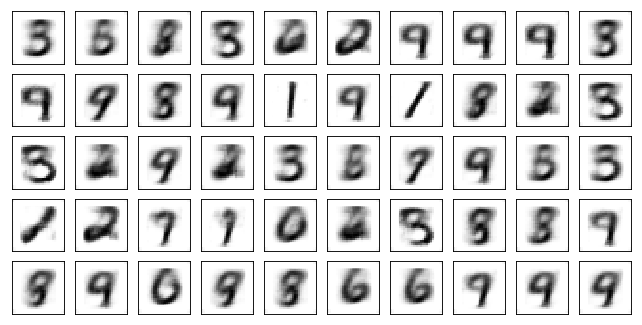

Test losses: VAE1: 0.2091/2.6248 VAE2: 0.1796/4.0577
Train Epoch: 22 [0/50000 (0%)]	Losses VAE1: 0.2286 VAE2: 0.2034
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE1: 0.2341 VAE2: 0.1982
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE1: 0.2065 VAE2: 0.1707
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE1: 0.2234 VAE2: 0.1936
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE1: 0.2068 VAE2: 0.1825
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE1: 0.2049 VAE2: 0.1757
VAE1


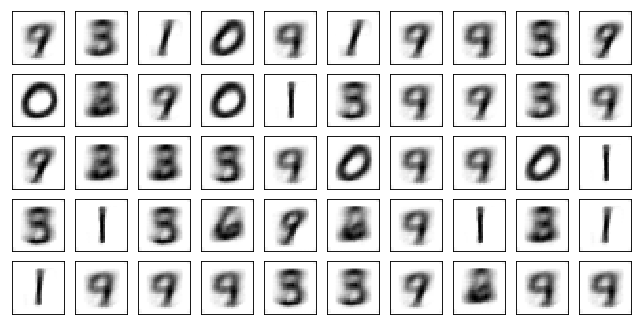

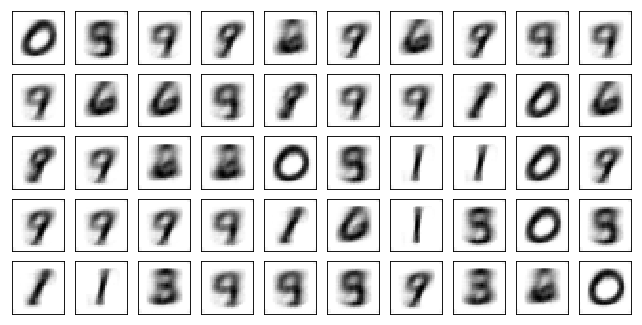

VAE2


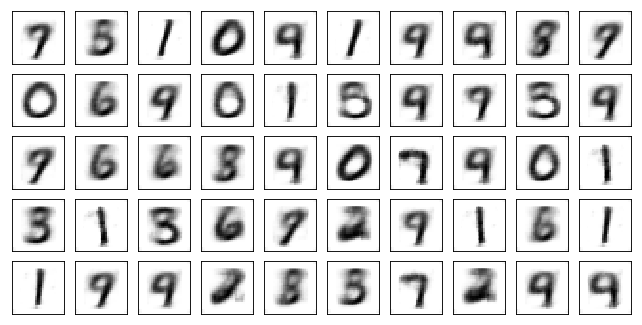

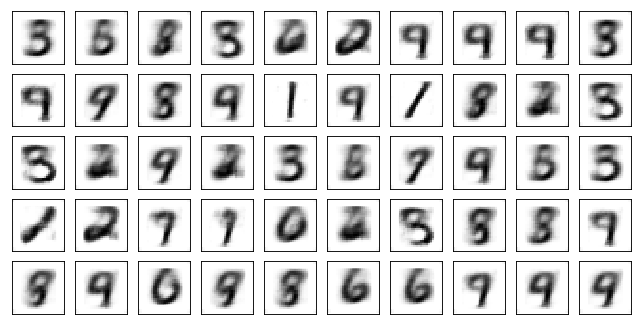

Test losses: VAE1: 0.2089/2.6045 VAE2: 0.1794/3.9882
Train Epoch: 23 [0/50000 (0%)]	Losses VAE1: 0.2111 VAE2: 0.1811
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE1: 0.2145 VAE2: 0.1874
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE1: 0.2142 VAE2: 0.1880
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE1: 0.1926 VAE2: 0.1715
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE1: 0.2060 VAE2: 0.1738
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE1: 0.2122 VAE2: 0.1827
VAE1


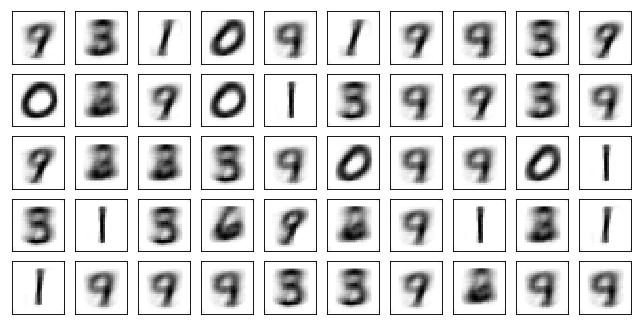

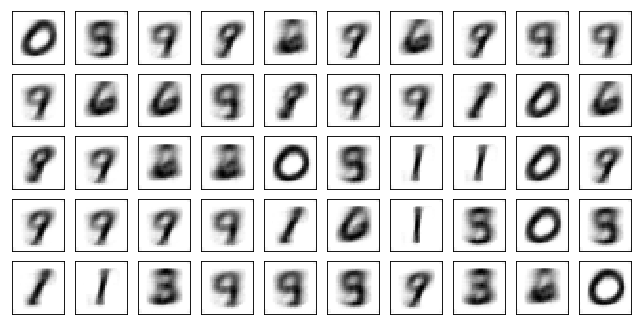

VAE2


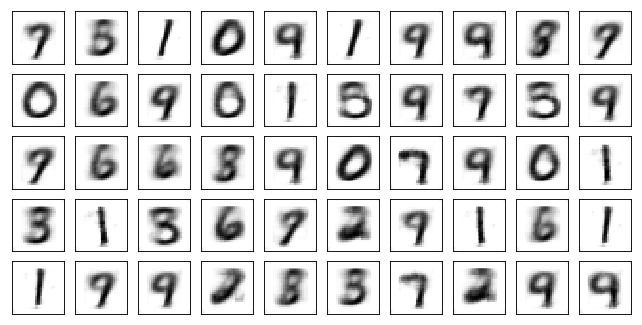

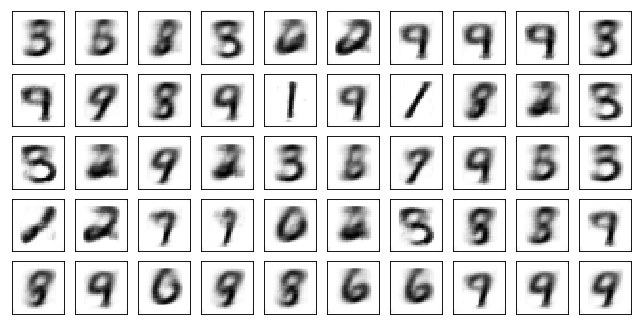

Test losses: VAE1: 0.2084/2.5386 VAE2: 0.1787/4.0106
Train Epoch: 24 [0/50000 (0%)]	Losses VAE1: 0.2132 VAE2: 0.1796
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE1: 0.2043 VAE2: 0.1801
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE1: 0.2143 VAE2: 0.1941
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE1: 0.2178 VAE2: 0.1848
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE1: 0.2165 VAE2: 0.1979
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE1: 0.1951 VAE2: 0.1679
VAE1


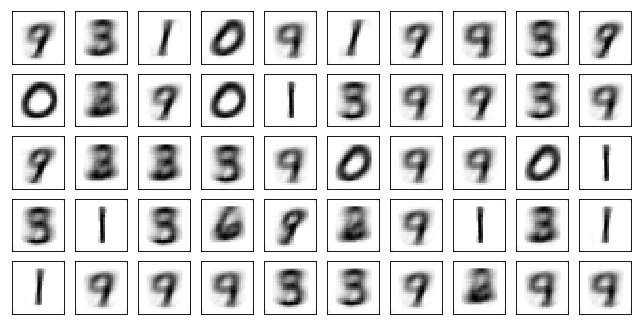

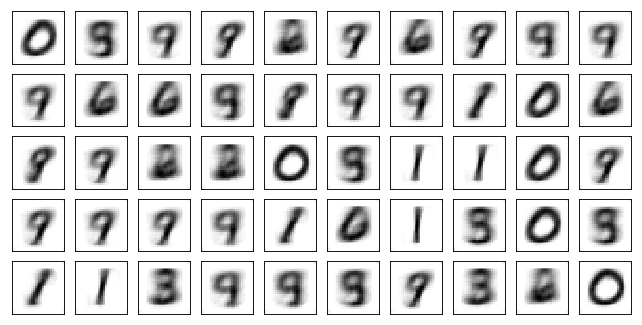

VAE2


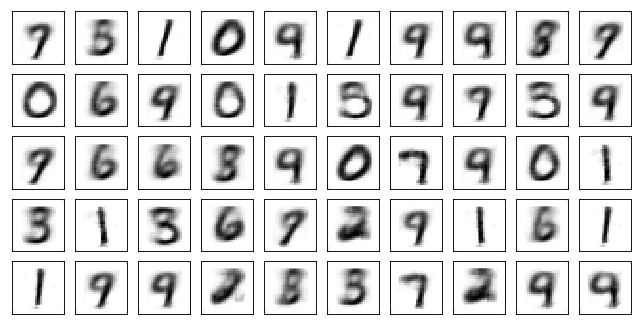

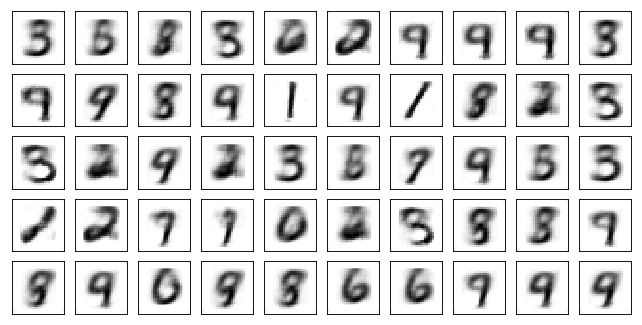

Test losses: VAE1: 0.2089/2.5659 VAE2: 0.1781/4.0566
Train Epoch: 25 [0/50000 (0%)]	Losses VAE1: 0.1997 VAE2: 0.1737
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE1: 0.2097 VAE2: 0.1801
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE1: 0.1970 VAE2: 0.1624
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE1: 0.2165 VAE2: 0.1910
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE1: 0.2170 VAE2: 0.1743
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE1: 0.2174 VAE2: 0.1942
VAE1


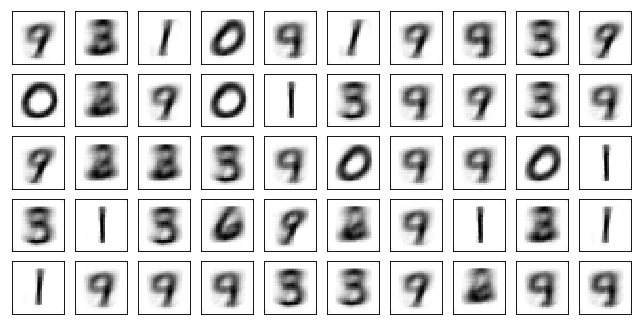

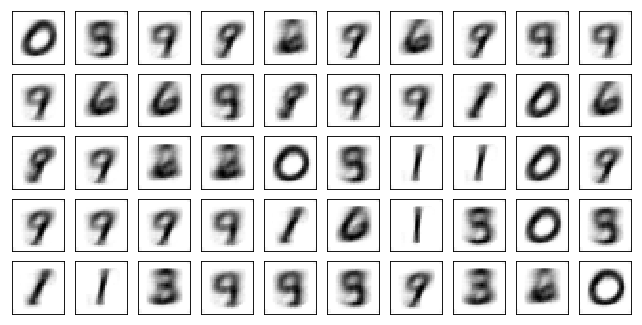

VAE2


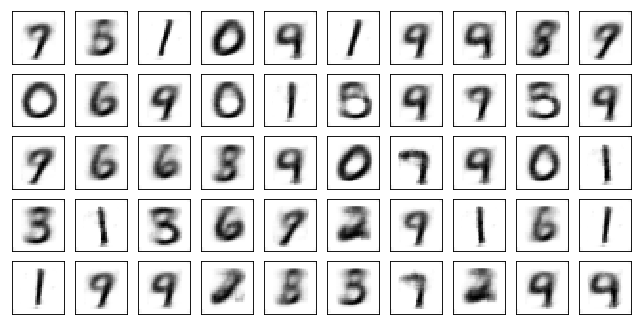

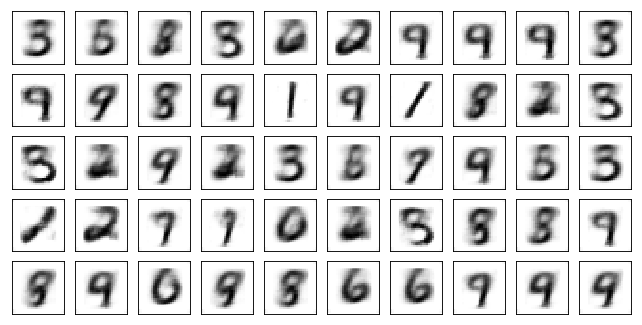

Test losses: VAE1: 0.2077/2.6710 VAE2: 0.1774/4.1530
Train Epoch: 26 [0/50000 (0%)]	Losses VAE1: 0.2031 VAE2: 0.1866
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE1: 0.1941 VAE2: 0.1738
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE1: 0.2177 VAE2: 0.1910
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE1: 0.1986 VAE2: 0.1759
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE1: 0.1946 VAE2: 0.1665
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE1: 0.1935 VAE2: 0.1673
VAE1


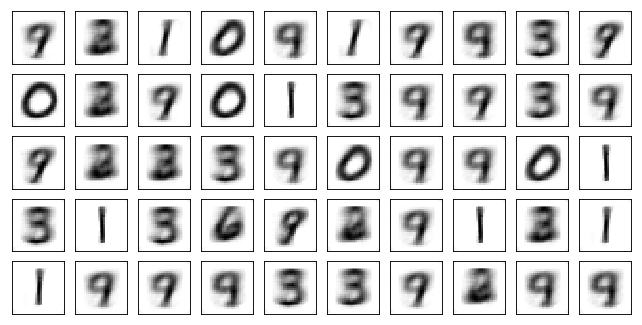

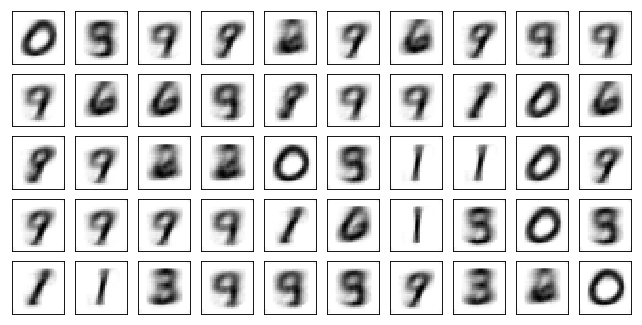

VAE2


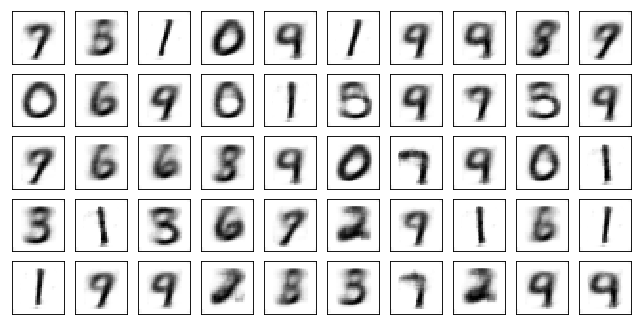

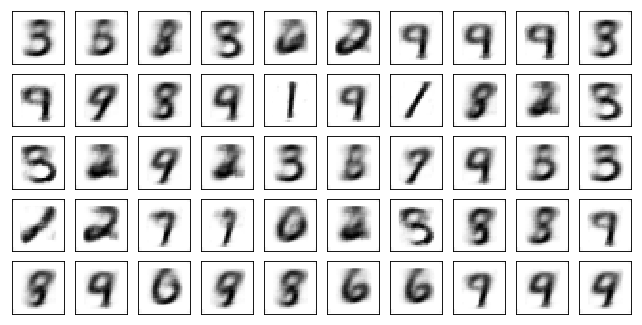

Test losses: VAE1: 0.2072/2.6742 VAE2: 0.1767/4.1040
Train Epoch: 27 [0/50000 (0%)]	Losses VAE1: 0.2192 VAE2: 0.1938
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE1: 0.2129 VAE2: 0.1815
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE1: 0.2135 VAE2: 0.1834
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE1: 0.2149 VAE2: 0.1900
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE1: 0.1796 VAE2: 0.1595
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE1: 0.1840 VAE2: 0.1625
VAE1


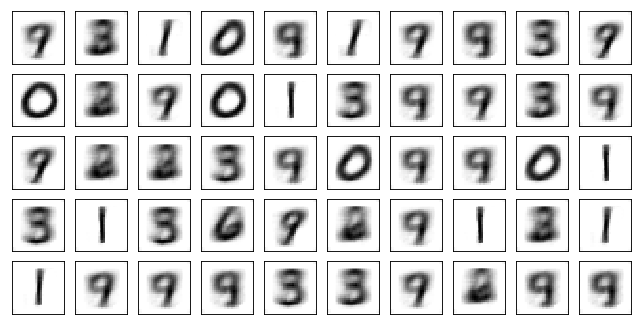

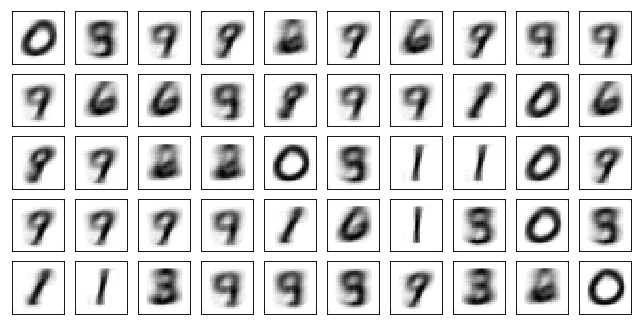

VAE2


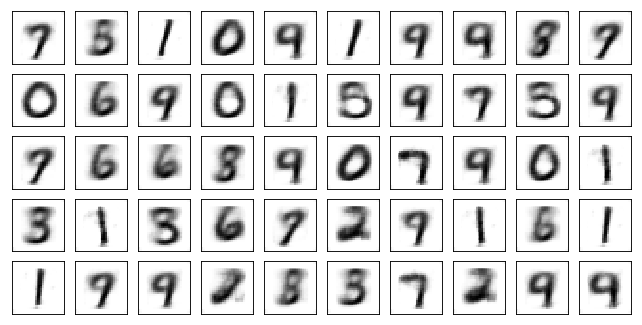

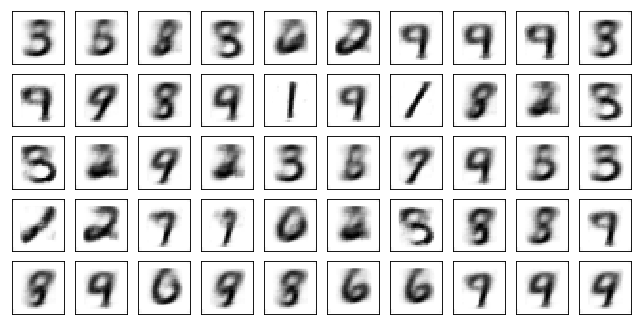

Test losses: VAE1: 0.2077/2.6658 VAE2: 0.1771/4.0983
Train Epoch: 28 [0/50000 (0%)]	Losses VAE1: 0.2098 VAE2: 0.1868
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE1: 0.1906 VAE2: 0.1653
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE1: 0.2209 VAE2: 0.1903
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE1: 0.2086 VAE2: 0.1909
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE1: 0.2264 VAE2: 0.1980
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE1: 0.2111 VAE2: 0.1828
VAE1


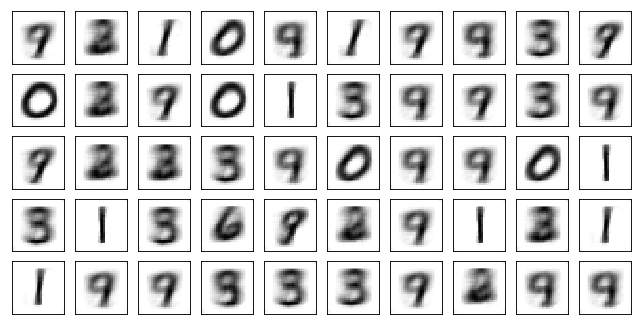

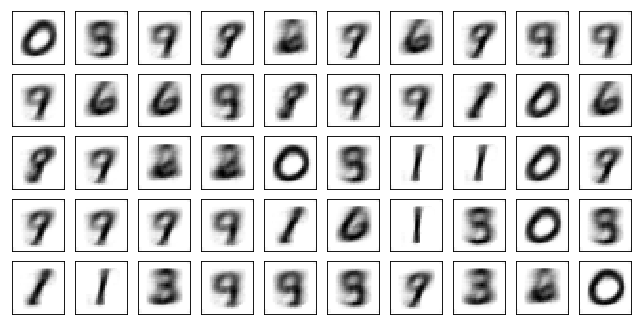

VAE2


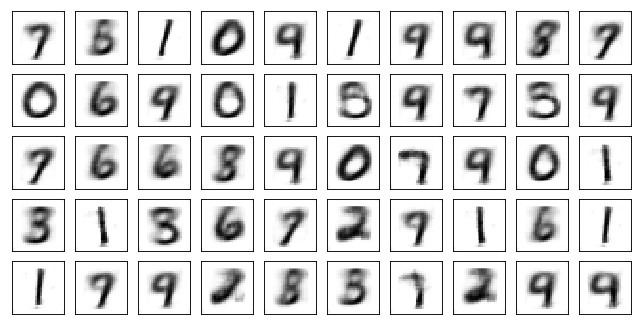

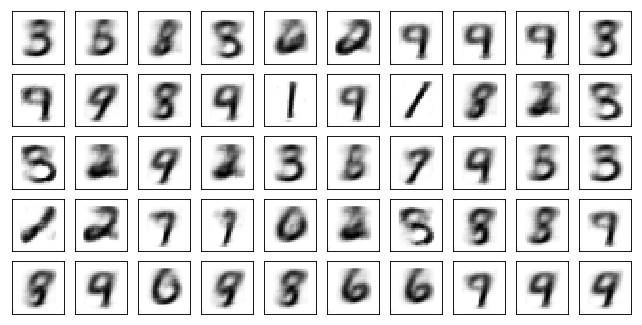

Test losses: VAE1: 0.2066/2.6291 VAE2: 0.1763/4.1434
Train Epoch: 29 [0/50000 (0%)]	Losses VAE1: 0.2139 VAE2: 0.1867
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE1: 0.2155 VAE2: 0.1868
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE1: 0.1977 VAE2: 0.1689
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE1: 0.1977 VAE2: 0.1720
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE1: 0.2008 VAE2: 0.1652
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE1: 0.1997 VAE2: 0.1673
VAE1


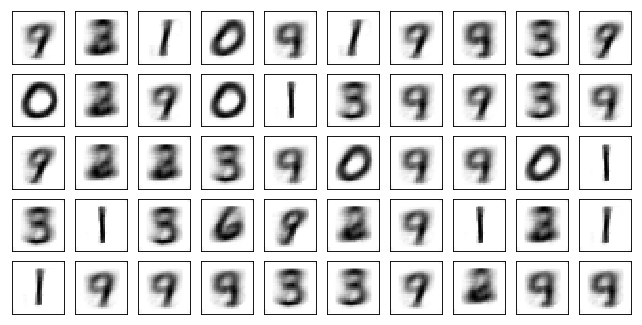

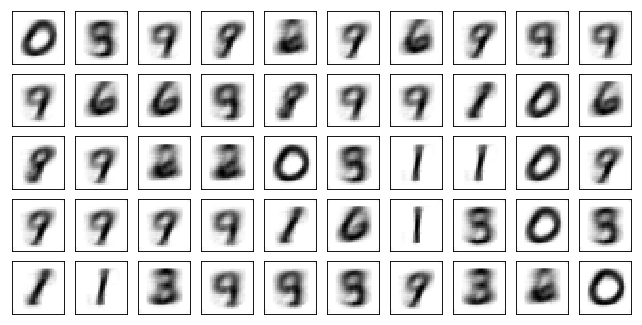

VAE2


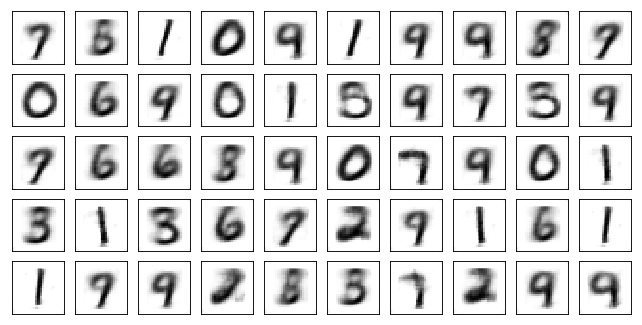

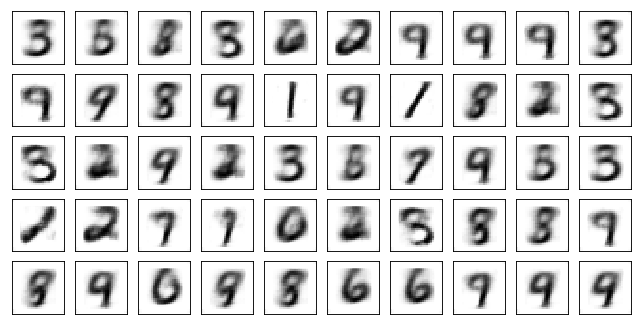

Test losses: VAE1: 0.2061/2.6901 VAE2: 0.1754/4.1724
Train Epoch: 30 [0/50000 (0%)]	Losses VAE1: 0.2171 VAE2: 0.1935
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE1: 0.2112 VAE2: 0.1841
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE1: 0.2041 VAE2: 0.1738
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE1: 0.1970 VAE2: 0.1679
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE1: 0.2170 VAE2: 0.1810
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE1: 0.2045 VAE2: 0.1717
VAE1


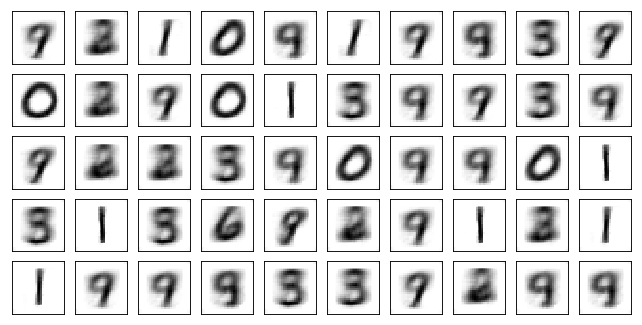

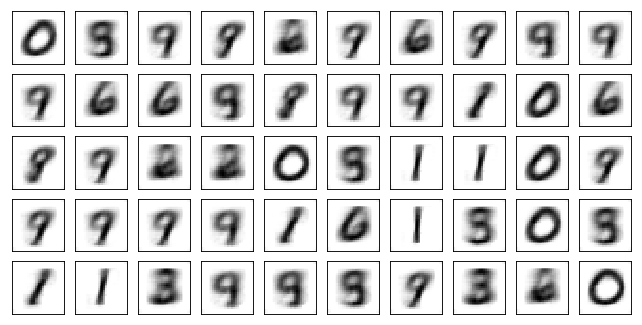

VAE2


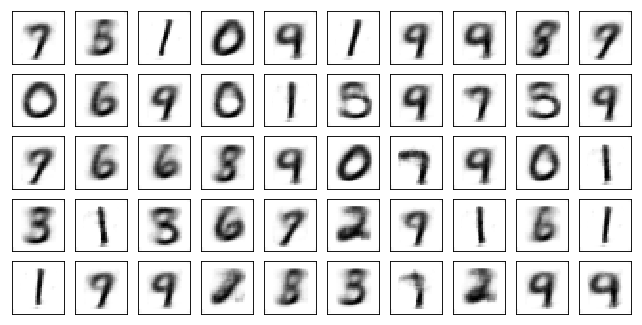

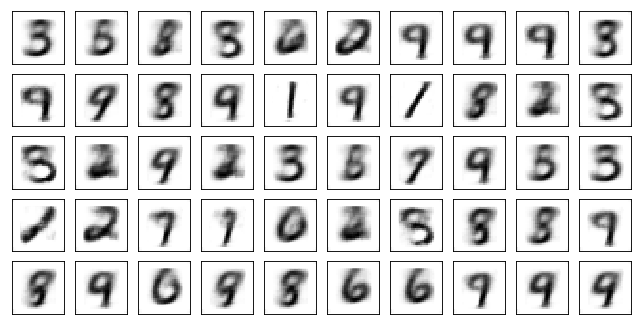

Test losses: VAE1: 0.2058/2.6991 VAE2: 0.1757/4.1468
CPU times: user 14min 23s, sys: 3min 20s, total: 17min 44s
Wall time: 13min 46s


In [13]:
%%time
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [14]:
for k, m in models.items():
    torch.save(models[k].state_dict(), f"{k}.model.pt")

## Decode numbers from 1-dimentional range to images with VAE1 model

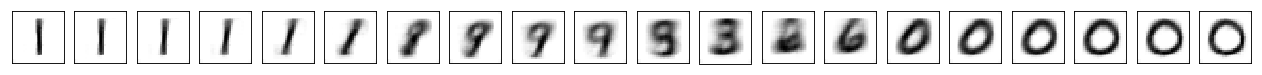

In [15]:
models['VAE1'].eval()
n_points = 20
data1 = torch.tensor(np.linspace(-3,3,n_points)).unsqueeze(dim=1).float().cuda()
dec1 = models['VAE1'].decode(data1)
plot_mnist(dec1.detach().cpu().numpy(), (1, n_points))

## Decode numbers from 2-dimentional range to images with VAE2 model

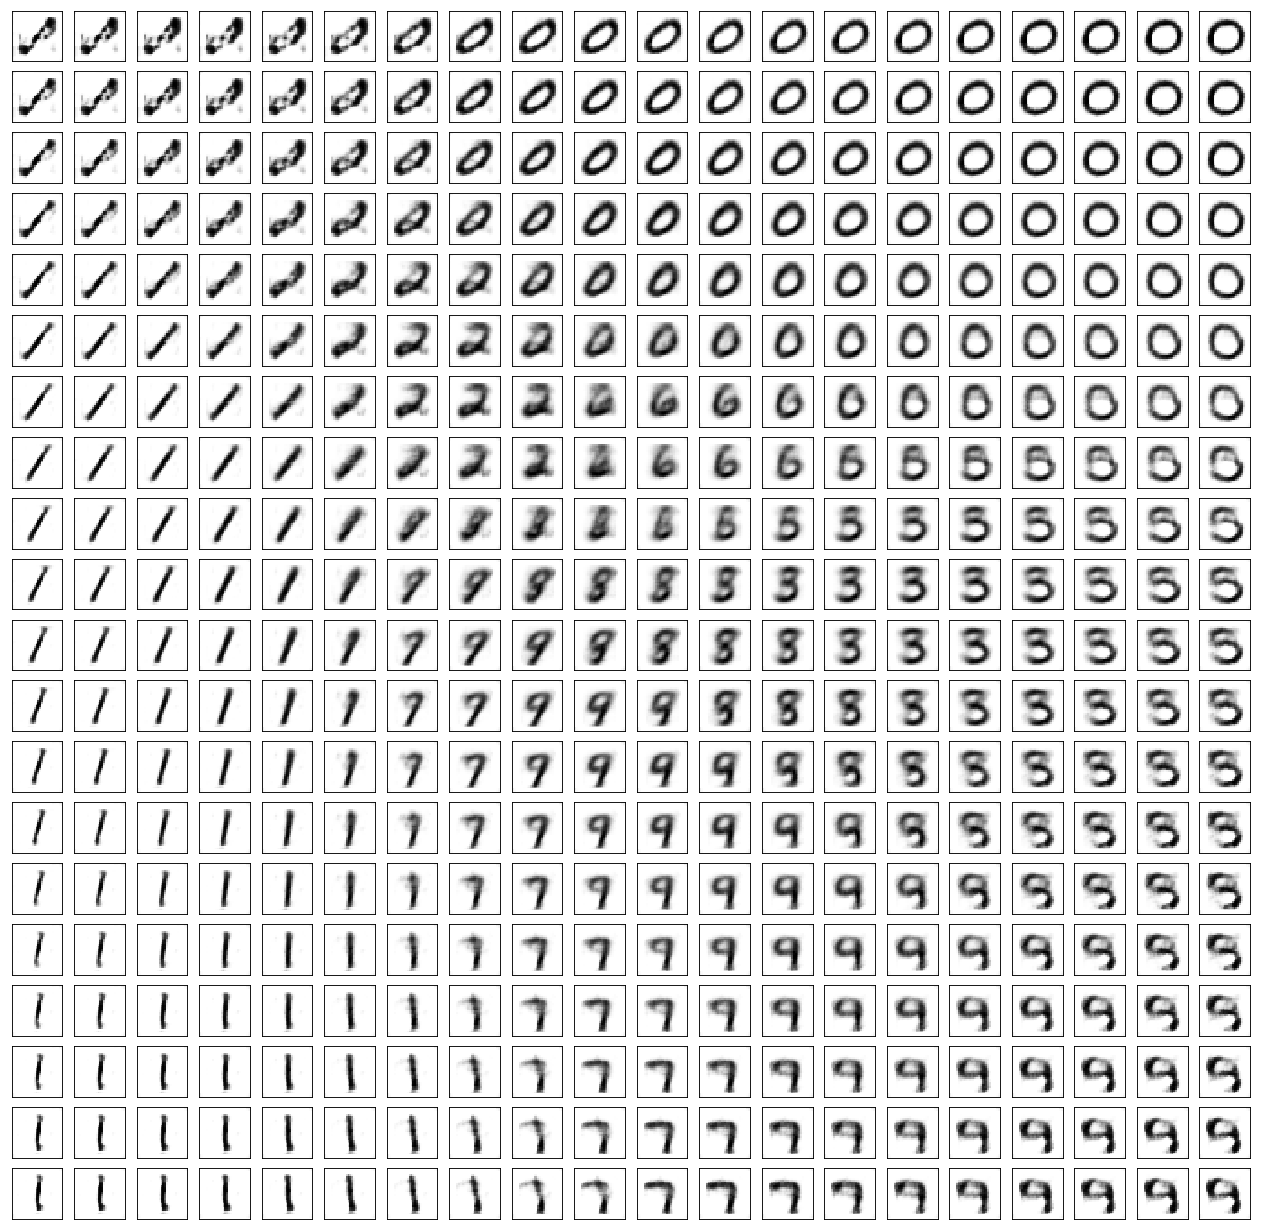

In [16]:
models['VAE2'].eval()
n_points = 20
import itertools
data2 = torch.zeros(n_points*n_points,2).cuda()
for t, (i, j) in enumerate(itertools.product(np.linspace(-3,3,n_points),np.linspace(-3,3,n_points))):
    data2[t,:]=torch.tensor((i,j))
dec2 = models['VAE2'].decode(data2)
plot_mnist(dec2.detach().cpu().numpy(), (n_points, n_points))